# Germline analysis in Fig 5K

In [1]:
from collections import Counter

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
np.random.seed(426749)
import pandas as pd

In [2]:
def filter_sig_muts(df, signature): 
    """Filter a dataframe for mutations within a signature and maximum likelihood > 0.5"""
    
    df = df.loc[df['SIGNATURE'] == signature].copy()
    df = df.loc[df['MAX_PROB'] > 0.5].copy()
    return df

In [3]:
def compute_hotspot_propensity(df, total_iterations, sample_size, mutations_size):
    """Carry out the subsampling to compute hotspot propensity"""
    
    hotspots_per_iteration = []

    # Filter samples for subsampling
    muts_per_sample = dict(df['SAMPLE'].value_counts())
    muts_per_sample_filter = dict([(k, v) for k, v in muts_per_sample.items() if v > mutations_size])
    filtered_samples = list(muts_per_sample_filter.keys())

    # Subsampling
    for iteration in range(0, total_iterations):
        # Select a number of samples randomly without replacement (a sample cannot be selected twice in the subsample)
        subsample = np.random.choice(filtered_samples, size=sample_size, replace=False)

        # Randomize mutations
        iter_mutations_df = []
        for sample in subsample:
            sample_df = df.loc[df['SAMPLE'] == sample].copy()
            # Select a number of mutations randomly without replacement (a mutation cannot be selected twice)
            sample_muts_df = sample_df.sample(n=mutations_size, replace=False).copy()
            iter_mutations_df.append(sample_muts_df)
        # Merge
        iter_mutations_df = pd.concat(iter_mutations_df)
        # Identify hotspots (two or more mutations in the same position)
        randomised_mutations = iter_mutations_df['MUTATION_ID'].tolist()
        hotspots = [h for h, nmuts in Counter(randomised_mutations).items() if nmuts >= 2]
        hotspots_position = set(['_'.join(i.split('_')[:2]) for i in hotspots])
        hotspots_per_iteration += [len(hotspots_position)]

        if len(hotspots) != len(hotspots_position): 
            print(len(hotspots), len(hotspots_position))

    return hotspots_per_iteration

In [4]:
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

In [5]:
sigs_color = {
'SBS1': '#1e79baff',
 'SBS5': '#7ebdeaff'
}

In [6]:
data_dir = '../../../data/germline_mutations'

### Load data

- Filtered germline mutations from human. Each mutation has been assigned to the signature with maximum likelihood. 

In [7]:
files = [
    f'{data_dir}/An_2018.parsed.mappable.max_likelihood.tsv',
    f'{data_dir}/Goldman_2016.parsed.mappable.max_likelihood.tsv',
    f'{data_dir}/Halldorsson_2019.parsed.mappable.max_likelihood.tsv',
    f'{data_dir}/Rahbari_2015.parsed.mappable.max_likelihood.tsv',
    f'{data_dir}/Sasani_2019__second_gen.parsed.mappable.max_likelihood.tsv',
    f'{data_dir}/Sasani_2019__third_gen.parsed.mappable.max_likelihood.tsv',
    f'{data_dir}/Yuen_2017.parsed.mappable.max_likelihood.tsv'
]

In [8]:
# Merge
lines = []
for file in files: 
    lines.append(pd.read_csv(file, sep='\t', header=0, low_memory=False))
mutations_df = pd.concat(lines)
len(mutations_df)

527612

In [9]:
mutations_df.head()

,SAMPLE,CHROMOSOME,POSITION,REF,ALT,MUT_ID,CONTEXT,MAX_PROB,SIGNATURE
0,An_2018,1,3747728,T,C,1_3747728_T>C,TTG>C,0.995147,SBS5
1,An_2018,1,38338861,C,A,1_38338861_C>A,ACT>A,0.971976,SBS5
2,An_2018,1,117942118,T,G,1_117942118_T>G,TTA>G,1.000000,SBS5
3,An_2018,1,163337297,C,A,1_163337297_C>A,TCT>A,0.999931,SBS5
4,An_2018,1,175991159,G,C,1_175991159_G>C,ACA>G,0.973312,SBS5


In [10]:
# Use ref and alt from hg38 across all datasets (info in context column)
mutations_df['REF'] = [i[1] for i in mutations_df['CONTEXT'].tolist()]
mutations_df['ALT'] = [i[-1] for i in mutations_df['CONTEXT'].tolist()]
mutations_df['MUTATION_ID'] = mutations_df.apply(
    lambda x: str(x['CHROMOSOME']) + '_' + str(x['POSITION']) + '_' + str(x['REF']) + '>' + str(x['ALT']), axis=1)

### Subset signatures

In [11]:
data = {}
data['SBS1'] = filter_sig_muts(df=mutations_df, signature='SBS1')
data['SBS5'] = filter_sig_muts(df=mutations_df, signature='SBS5')
for sig, df in data.items(): 
    print(sig, len(df))

SBS1 89799
SBS5 437813


### Compute hotspot propensity

In [12]:
total_iterations = 1000
n_mutations = 30000

#### SBS1

In [13]:
# Randomize mutations
hotspots_per_iteration_sbs1 = []
for iteration in range(0, total_iterations):
    
    # Select a number of mutations randomly without replacement (a mutation cannot be selected twice)
    subsample_df = data['SBS1'].sample(n=n_mutations, replace=False).copy()
    
    # Identify hotspots (two or more mutations in the same position)
    randomised_mutations = subsample_df['MUTATION_ID'].tolist()
    hotspots = [h for h, nmuts in Counter(randomised_mutations).items() if nmuts >= 2]
    hotspots_position = set(['_'.join(i.split('_')[:2]) for i in hotspots])
    hotspots_per_iteration_sbs1 += [len(hotspots_position)]

np.median(hotspots_per_iteration_sbs1)

97.0

#### SBS5

In [14]:
# Randomize mutations
hotspots_per_iteration_sbs5 = []
for iteration in range(0, total_iterations):
    
    # Select a number of mutations randomly without replacement (a mutation cannot be selected twice)
    subsample_df = data['SBS5'].sample(n=n_mutations, replace=False).copy()
    
    # Identify hotspots (two or more mutations in the same position)
    randomised_mutations = subsample_df['MUTATION_ID'].tolist()
    hotspots = [h for h, nmuts in Counter(randomised_mutations).items() if nmuts >= 2]
    hotspots_position = set(['_'.join(i.split('_')[:2]) for i in hotspots])
    hotspots_per_iteration_sbs5 += [len(hotspots_position)]

np.median(hotspots_per_iteration_sbs5)

25.0

## Panel 5K

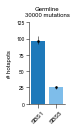

In [15]:
fig = plt.figure(figsize=(0.65, 1.5))
ax = plt.subplot2grid((1, 1), (0, 0))
ax.set_ylabel('# hotspots', fontsize=6)
plt.title(f"Germline\n30000 mutations", fontsize=6)

labels = ['SBS1', 'SBS5']
m1 = np.median(hotspots_per_iteration_sbs1)
m2 = np.median(hotspots_per_iteration_sbs5)

bar = ax.bar([0, 1], [m1, m2], width=0.80, align='center', color=[sigs_color['SBS1'], sigs_color['SBS5']], alpha=1, zorder=1)
ax.vlines(0, ymin=np.percentile(hotspots_per_iteration_sbs1, 25), ymax=np.percentile(hotspots_per_iteration_sbs1, 75), color='black', linestyle='-', lw=0.5, zorder=2)
ax.vlines(1, ymin=np.percentile(hotspots_per_iteration_sbs5, 25), ymax=np.percentile(hotspots_per_iteration_sbs5, 75), color='black', linestyle='-', lw=0.5, zorder=3)
ax.scatter(0, m1, color='black', marker='o', s=4, lw=0.5, edgecolor=None, zorder=2)
ax.scatter(1, m2, color='black', marker='o', s=4, lw=0.5, edgecolor=None, zorder=2)

ax.set_xlim(-0.5, 1.5)
ax.set_ylim(0, 125)
ax.set_xticks([0, 1])
ax.set_xticklabels(labels, fontsize=6, rotation=45, ha='center', va='top')
yticks = [0, 25, 50, 75, 100, 125]
ax.set_yticks(yticks)
ax.set_yticklabels(yticks, fontsize=5)
ax.tick_params(axis='y', which='major', pad=1)
ax.tick_params(axis='x', which='major', pad=2)

ax.spines['left'].set(lw=0.5)
ax.spines['bottom'].set(lw=0.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_tick_params(width=0.5)
ax.yaxis.set_tick_params(width=0.5)

for extension in ['png']: 
    output = f'./fig_5K.{extension}'
    plt.savefig(output, bbox_inches='tight', dpi=350)